In [94]:
# coding: utf-8

from collections import Counter
import ConfigParser
from datetime import datetime
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
import re
import nltk
# import seaborn as sns
import string
from time import time
import tweepy
from matplotlib import pylab as plt
import pandas as pd
import pickle

# nltk.download('punkt')
# nltk.download('stopwords')

In [95]:
Config = ConfigParser.ConfigParser()
Config.read('./config')
consumer_key = Config.get('api', 'consumer_key')
consumer_secret = Config.get('api', 'consumer_secret')
access_token = Config.get('api', 'access_token')
access_secret = Config.get('api', 'access_secret')

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth)

In [98]:
# Do not forget rate limit of 15 calls per 15 min window
limits = api.rate_limit_status()
search_limits = limits['resources']['search']['/search/tweets']
print('Remaining calls: ' + str(search_limits['remaining']))
print('Limit resets in ' + str(round(search_limits['reset'] - time(), 0)) + 's')

Remaining calls: 179
Limit resets in 883.0s


In [105]:
search_term = 'apple'
result = api.search(q=search_term, count=100, rpp=100)

# pickle.dump( result, open( "sample_data.p", "wb" ) )
# result = pickle.load( open( "sample_data.p", "rb" ) )

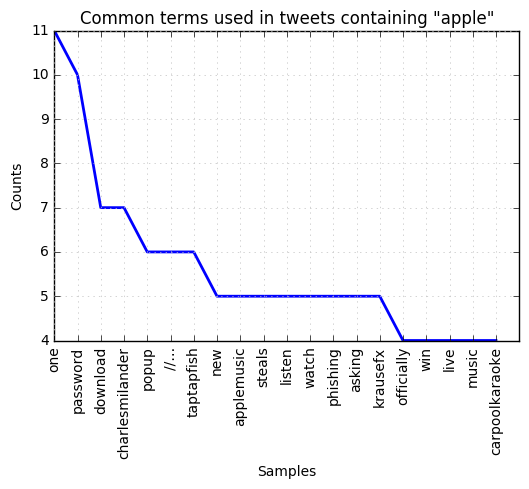

In [106]:
def parse(tokens):
    parsed = []
    for token in tokens:
        if len(token) < 3:
            continue
        regex = re.compile(ur'//[\.\w+/]+|http\\\w+|\w+\u2026|\w\'\w', re.IGNORECASE)    

        if regex.match(token):
             continue
        punctuation = list(string.punctuation)
        unwanted = ['rt', 'via', 'u', 'Did', 'n', '#', 'https',
            search_term, '..', '...', 'may']
        stop = stopwords.words('english') + punctuation + unwanted    
        
        if token in stop:
            continue
            
        parsed.append(token)
    return parsed

count_all = Counter()
tokens = []
for i in result:
    # consider using POS tagging to keep only lexical terms
    tokens.extend(word_tokenize(i.text.lower().translate(dict.fromkeys(string.punctuation))))

tokens = parse(tokens)

count_all.update(tokens)
tally = count_all.most_common(20)
fd = FreqDist(tokens)
fd.plot(20, title='Common terms used in tweets containing \"' + search_term + '\"', cumulative=False)

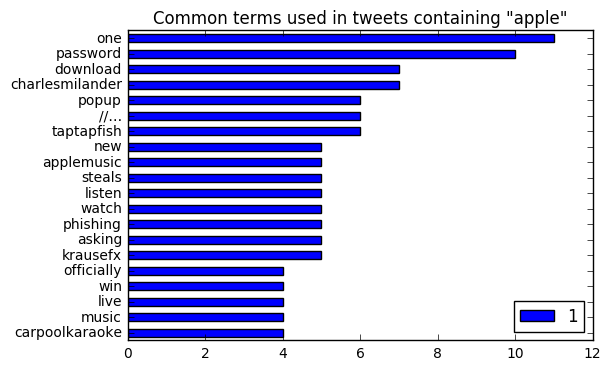

In [107]:
%matplotlib inline
plt.clf()
df = pd.DataFrame.from_records(tally).iloc[::-1]

ax = df.plot.barh(title='Common terms used in tweets containing \"' + search_term + '\"')
_ = ax.set_yticklabels(df[0])

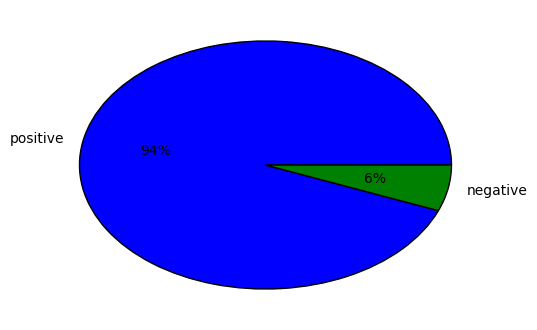

In [104]:
pos_tweets = [('I love this', 'positive'),
              ('The effect was amazing', 'positive'),
              ('I feel great this morning', 'positive'),
              ('I am so excited', 'positive'),
              ('I am happy', 'positive')]

neg_tweets = [('I do not like this', 'negative'),
              ('This is horrible', 'negative'),
              ('I feel tired this morning', 'negative'),
              ('I am not looking forward to this', 'negative'),
              ('I feel bad', 'negative')]

tweets = []
for (words, sentiment) in pos_tweets + neg_tweets:
    words_filtered = [e.lower() for e in words.split() if len(e) >= 3] 
    tweets.append((words_filtered, sentiment))

def get_words_in_tweets(tweets):
    all_words = []
    for (words, sentiment) in tweets:
      all_words.extend(words)
    return all_words

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    word_features = wordlist.keys()
    return word_features

word_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

training_set = nltk.classify.apply_features(extract_features, tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

neg = 0.0
pos = 0.0
for i in result:
    if classifier.classify(extract_features(i.text.split())) == 'positive':
        pos += 1.0
    else:
        neg += 1.0

_ = plt.pie([pos, neg], autopct='%.0f%%', labels=['positive', 'negative'])